## Classification
### Stroke Prediction Dataset

#### Attribute Information:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [721]:
import pandas as pd
import numpy as np

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import toad
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import dalex as dx

In [722]:
df = pd.read_csv(r'C:\Users\HP\Desktop\szkolne\5 rok\ml2\ML2-project\data\c1.csv')

list_dummies = ['ever_married', 'smoking_status', 'Residence_type', 'work_type', 'gender']
df = pd.get_dummies(df, columns=[var for var in list_dummies], drop_first=True)
df.drop(columns = ['id'], inplace=True)

In [723]:
df.columns

Index(['age', 'avg_glucose_level', 'bmi', 'feat01', 'feat02', 'feat03',
       'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09', 'feat10',
       'heart_disease', 'hypertension', 'stroke', 'ever_married_Yes',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'Residence_type_Urban',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'gender_Male',
       'gender_Other'],
      dtype='object')

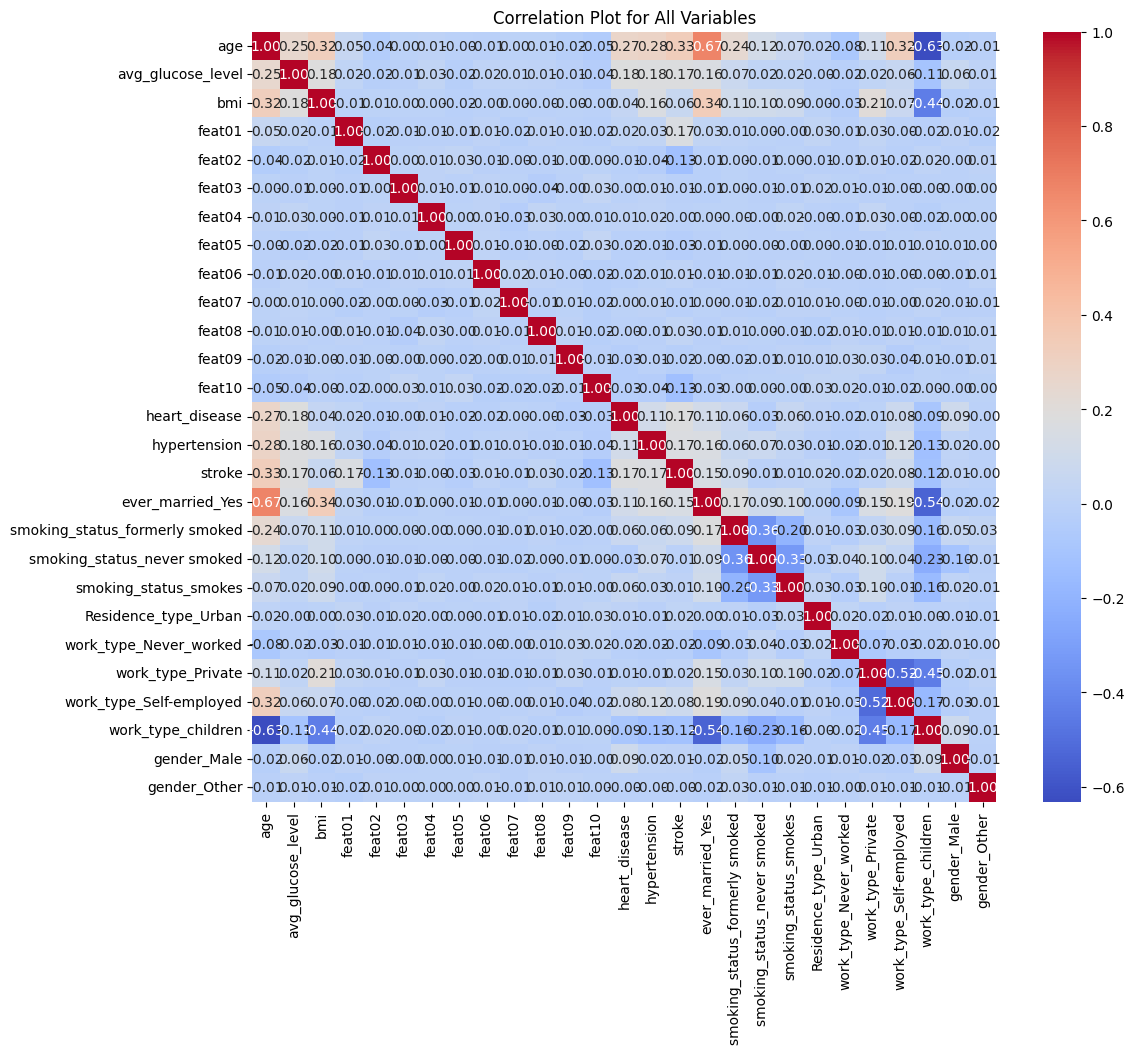

In [724]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot for All Variables')
plt.show()


In [725]:
df.head()

,age,avg_glucose_level,bmi,feat01,feat02,feat03,feat04,feat05,feat06,feat07,...,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Urban,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,gender_Male,gender_Other
0,43.000,92.710,30.500,0.622,0.664,1.070,1.274,1.391,1.096,1.071,...,1,0,0,1,0,1,0,0,1,0
1,59.000,93.900,42.200,0.286,0.405,1.272,0.950,1.560,1.151,1.110,...,0,1,0,0,0,1,0,0,1,0
2,25.000,92.140,36.200,0.696,0.496,1.467,1.026,0.514,1.041,0.870,...,0,0,0,0,0,1,0,0,1,0
3,74.000,205.840,54.600,0.718,0.408,0.644,0.895,0.965,0.891,1.499,...,0,1,0,1,0,0,1,0,0,0
4,34.000,79.800,37.400,0.472,0.464,1.161,1.308,0.803,1.571,0.319,...,0,0,1,1,0,1,0,0,0,0


### Data split

In [726]:
X = df.drop(['stroke'], axis=1)
y = df['stroke']

lbl = preprocessing.LabelEncoder() 
# col_invalid = ['ever_married', 'gender', 'Residence_type', 'smoking_status', 'work_type']
# for col in col_invalid:
#     X[col] = lbl.fit_transform(X[col].astype(str))



seed = 15
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [727]:
X_train.columns



Index(['age', 'avg_glucose_level', 'bmi', 'feat01', 'feat02', 'feat03',
       'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09', 'feat10',
       'heart_disease', 'hypertension', 'ever_married_Yes',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'Residence_type_Urban',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'gender_Male',
       'gender_Other'],
      dtype='object')

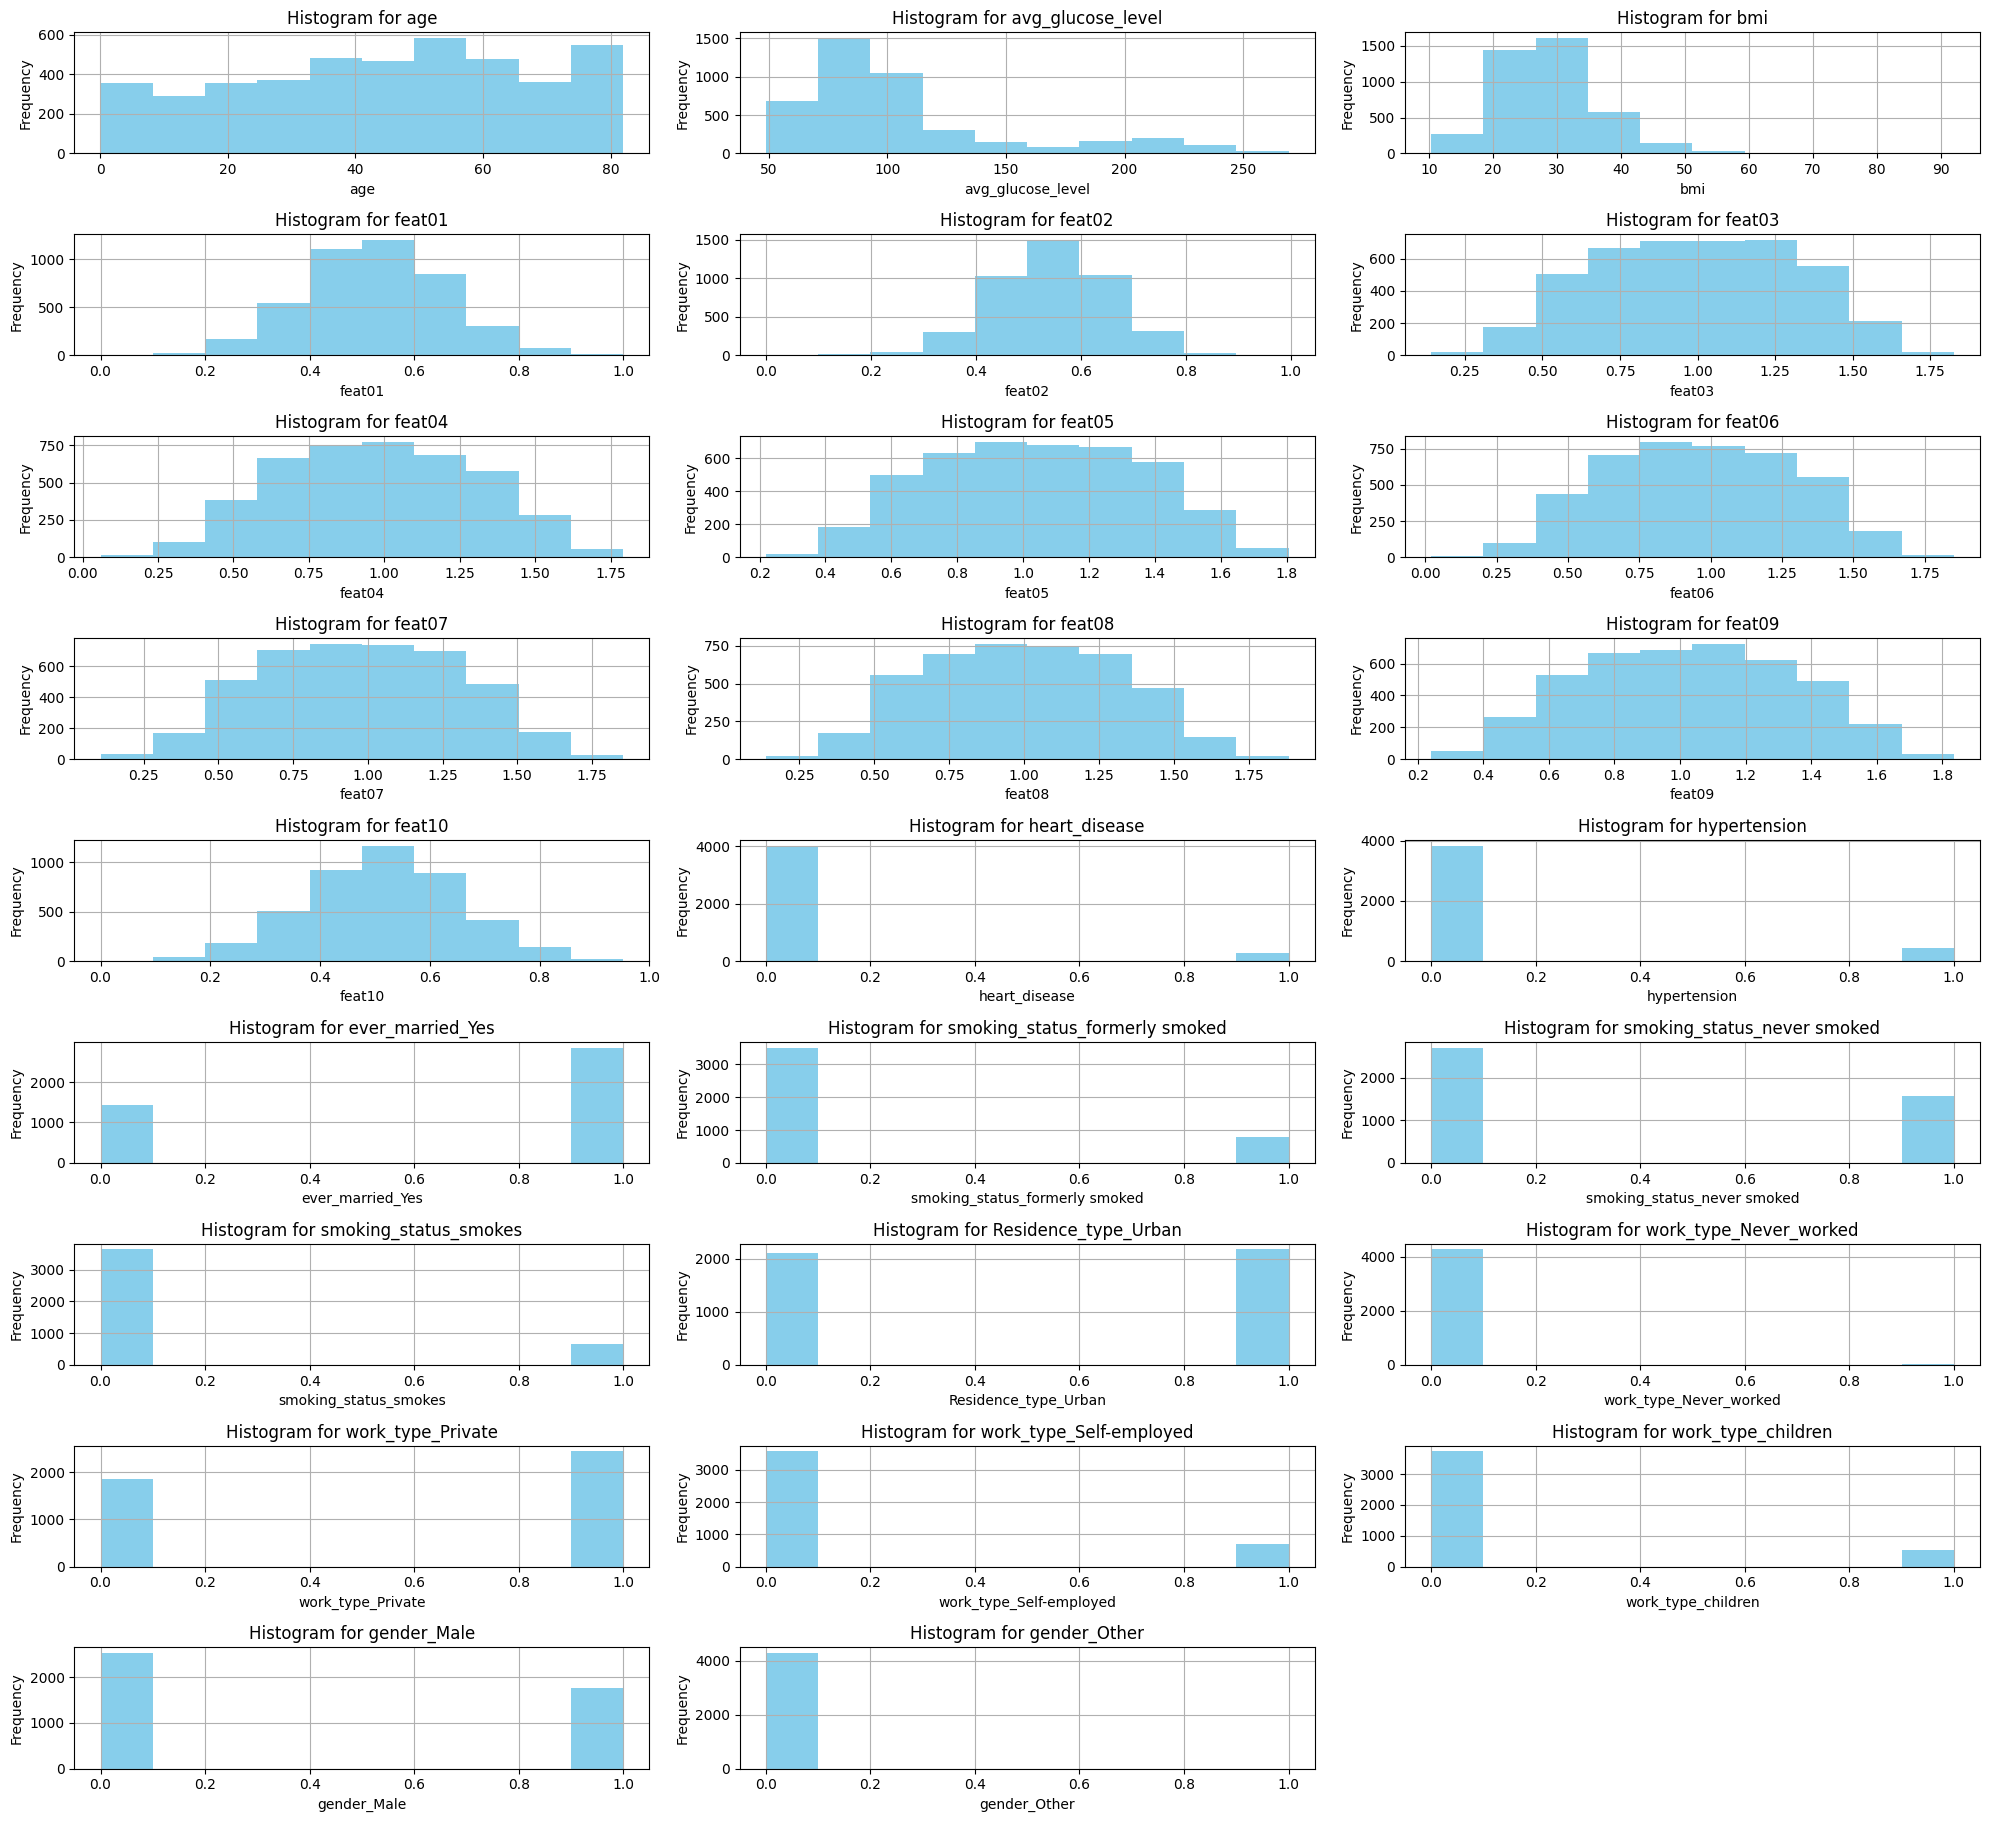

In [728]:
# Set up subplots with 2 columns and 7 rows
num_rows = 15
num_columns = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 30))

# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

# Plot histograms for each variable on separate subplots
for i, variable in enumerate(X_train.columns):
    X_train[variable].hist(ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram for {variable}')
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots if there are fewer variables than total subplots
for j in range(len(X_train.columns), num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

In [729]:
vars_to_bin = ['age','avg_glucose_level', 'bmi', 'feat03', 'feat05']

for var in vars_to_bin:    
    X_test[var] = X_test[var].fillna(X_test[var].median())
    quantiles = np.percentile(X_test[var], [0, 25, 50, 75, 100])
    print(quantiles)
    # Define bins based on quantiles
    # bins = [quantiles[0], quantiles[1], quantiles[2], quantiles[75], quantiles[100]]

    # Use pd.cut to bin the 'Age' variable
    X_test[var+'_group'] = pd.cut(X_test[var], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')

    X_test =  X_test.drop([var], axis=1)

    
X_test = pd.get_dummies(X_test, columns=[var+'_group' for var in vars_to_bin], drop_first=True)

for col in X_test.columns:
    if col.endswith('.0'):
        new_col_name = col[:-2]  # Remove the ".0" at the end
        X_test.rename(columns={col: new_col_name}, inplace=True)

X_test.head()


[ 0.24 26.   46.   62.   82.  ]
[ 55.23    77.9825  92.345  118.92   271.74  ]
[13.2   24.4   28.7   32.825 97.6  ]
[0.19589732 0.73398353 0.99044791 1.24744902 1.74617083]
[0.28989827 0.82402106 1.06406014 1.30644424 1.79666385]


,feat01,feat02,feat04,feat06,feat07,feat08,feat09,feat10,heart_disease,hypertension,...,avg_glucose_level_group_3,bmi_group_1,bmi_group_2,bmi_group_3,feat03_group_1,feat03_group_2,feat03_group_3,feat05_group_1,feat05_group_2,feat05_group_3
3790,0.479,0.469,1.194,0.447,0.748,1.023,0.957,0.687,0,0,...,0,0,0,0,1,0,0,0,1,0
4104,0.778,0.612,1.153,1.554,1.200,0.994,0.489,0.700,0,0,...,0,0,0,0,0,0,0,1,0,0
1329,0.620,0.329,0.393,1.115,1.011,0.654,1.638,0.651,0,0,...,0,1,0,0,0,0,1,0,0,1
1530,0.642,0.508,0.549,0.369,0.651,1.003,1.455,0.654,0,0,...,0,0,1,0,0,0,1,0,0,1
1595,0.553,0.482,1.321,0.817,1.160,1.323,1.379,0.486,0,0,...,0,0,0,0,0,0,0,0,0,1


In [730]:
vars_to_bin = ['age','avg_glucose_level', 'bmi', 'feat03', 'feat05']

for var in vars_to_bin:    
    X_train[var] = X_train[var].fillna(X_train[var].median())
    quantiles = np.percentile(X_train[var], [0, 25, 50, 75, 100])
    print(quantiles)
    # Define bins based on quantiles
    # bins = [quantiles[0], quantiles[1], quantiles[2], quantiles[75], quantiles[100]]

    # Use pd.cut to bin the 'Age' variable
    X_train[var+'_group'] = pd.cut(X_train[var], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')

    X_train =  X_train.drop([var], axis=1)

    
X_train = pd.get_dummies(X_train, columns=[var+'_group' for var in vars_to_bin], drop_first=True)

for col in X_train.columns:
    if col.endswith('.0'):
        new_col_name = col[:-2]  # Remove the ".0" at the end
        X_train.rename(columns={col: new_col_name}, inplace=True)

X_train.head()

[8.0e-02 2.6e+01 4.6e+01 6.2e+01 8.2e+01]
[ 48.78  77.14  92.22 114.46 269.12]
[10.3 23.8 28.  32.8 92. ]
[0.14130948 0.73856514 0.99981744 1.25283842 1.825912  ]
[0.21886148 0.79518938 1.03853078 1.29257767 1.80572623]


,feat01,feat02,feat04,feat06,feat07,feat08,feat09,feat10,heart_disease,hypertension,...,avg_glucose_level_group_3,bmi_group_1,bmi_group_2,bmi_group_3,feat03_group_1,feat03_group_2,feat03_group_3,feat05_group_1,feat05_group_2,feat05_group_3
3409,0.570,0.606,1.368,0.575,0.480,1.261,0.797,0.438,0,0,...,0,0,0,0,0,0,0,0,0,0
1228,0.661,0.359,1.153,0.990,1.080,1.427,1.200,0.455,1,0,...,1,1,0,0,0,0,0,0,0,0
1116,0.422,0.537,1.466,1.265,0.833,1.316,1.360,0.446,0,0,...,0,1,0,0,0,0,0,0,0,0
1014,0.603,0.611,0.491,0.592,1.372,0.725,1.573,0.558,0,0,...,0,1,0,0,1,0,0,0,0,0
3834,0.667,0.611,0.705,0.761,1.443,1.176,0.789,0.552,0,0,...,1,0,0,1,0,0,0,0,0,1


In [731]:
cols_to_drop = ['smoking_status_formerly smoked' , 'gender_Other', 'work_type_Never_worked','bmi_group_3', 'work_type_Self-employed']

# 'Residence_type_Urban', 'gender_Male' feat05_group_1, age_group_1, 'smoking_status_never smoked', 'ever_married_Yes'

X_train = X_train.drop(columns = cols_to_drop)
X_test = X_test.drop(columns = cols_to_drop)

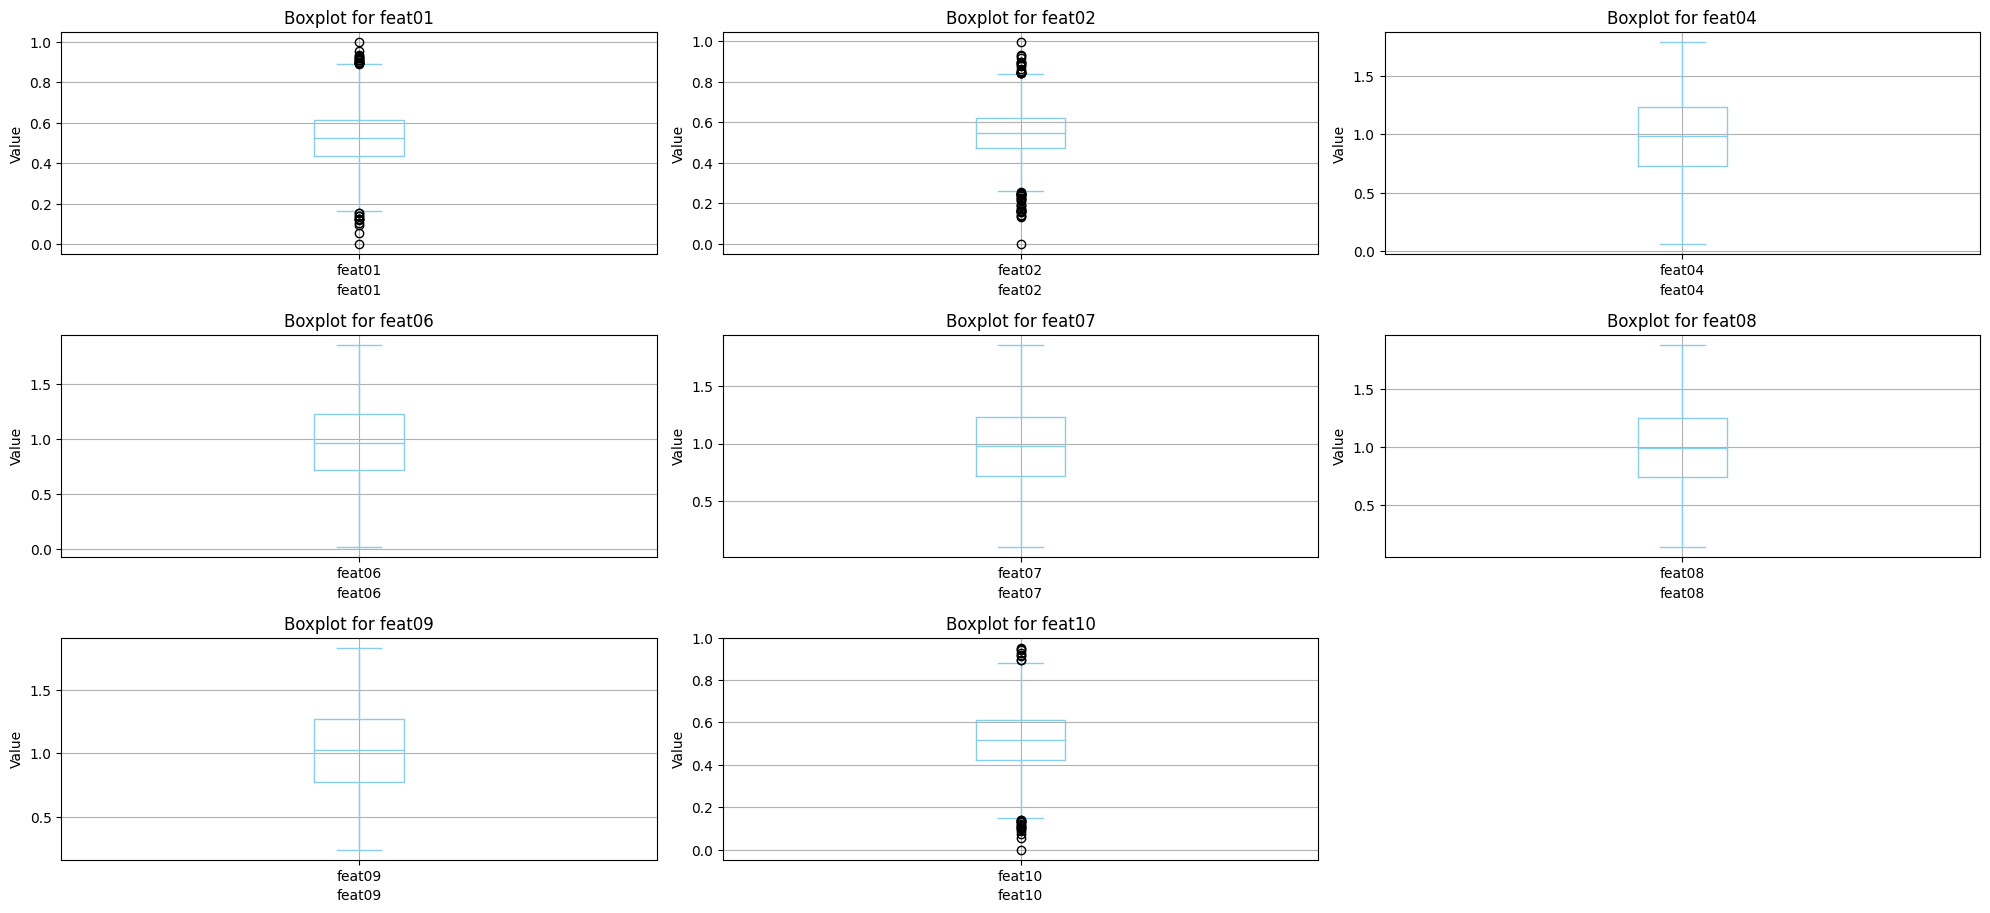

In [732]:
variables_to_plot = [col for col in X_train.columns if X_train[col].nunique() > 2]

# Set up subplots with 2 columns and 7 rows
num_rows = 10
num_columns = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 30))

# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

# Plot boxplots for each variable on separate subplots
for i, variable in enumerate(variables_to_plot):
    X_train.boxplot(column=variable, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot for {variable}')
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Value')

# Remove any empty subplots if there are fewer variables than total subplots
for j in range(len(variables_to_plot), num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

(4287, 31)
(1072, 31)
Accuracy: 91.23%


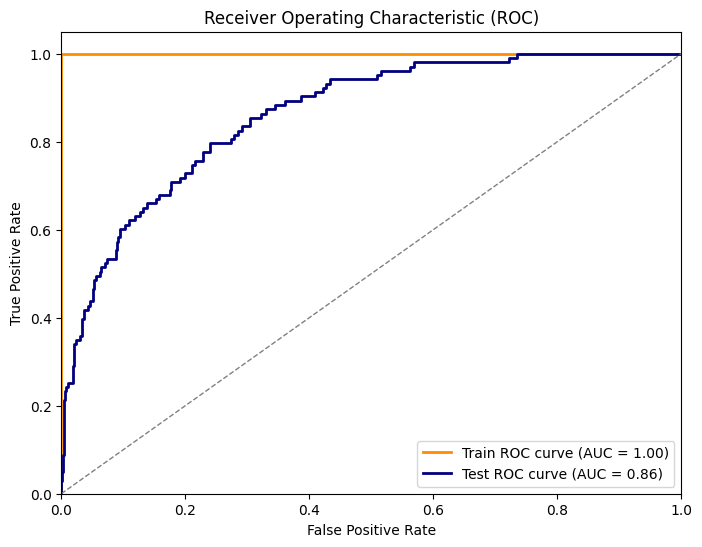

In [733]:
numerical_features = ['feat01', 'feat02',
        'feat04', 'feat06', 'feat07', 'feat08', 'feat09',
       'feat10']
# numerical_features.extend()
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_features = [ 'Residence_type_Urban', 'ever_married_Yes',
        'smoking_status_never smoked',
       'smoking_status_smokes', 'Residence_type_Urban',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
    #    'gender_Other',
         'age_group_1', 'age_group_2', 'age_group_3',
       'avg_glucose_level_group_1', 'avg_glucose_level_group_2',
       'avg_glucose_level_group_3', 'bmi_group_1', 'bmi_group_2',
       'feat03_group_1', 'feat03_group_2', 'feat03_group_3',
       'feat05_group_1', 'feat05_group_2', 'feat05_group_3', 'heart_disease', 'hypertension']



categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
        # ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



model = XGBClassifier()
# model.fit(X_train, y_train)

clf = Pipeline(steps=[
    # ('preprocessor', preprocessor),
                      ('classifier', model)])

print(X_train.shape)
print(X_test.shape)

clf.fit(X_train, y_train)


# # model.feature_importances_
# sorted_idx = clf.feature_importances_.argsort()
# plt.figure(figsize=(10,15))
# plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.show()


# fit model no training data


y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = clf.predict_proba(X_train)[:, 1]
y_test_prob = clf.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# model.feature_importances_
# sorted_idx = model.feature_importances_.argsort()
# plt.figure(figsize=(10,15))
# plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.show()

In [734]:
exp = dx.Explainer(clf, X_train, y_train)
imp = exp.model_parts(type = "variable_importance")
# plt.plot(imp)

Preparation of a new explainer is initiated

  -> data              : 4287 rows 31 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4287 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000026D91135080> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.88e-06, mean = 0.0922, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.123, mean = -0.000107, max = 0.213
  -> model_info        : package sklearn

A new explainer has been created!


In [735]:
imp

,variable,dropout_loss,label
0,Residence_type_Urban,0.000,XGBClassifier
1,smoking_status_smokes,0.000,XGBClassifier
2,smoking_status_never smoked,0.000,XGBClassifier
3,heart_disease,0.000,XGBClassifier
4,feat05_group_3,0.000,XGBClassifier
5,feat05_group_2,0.000,XGBClassifier
6,feat05_group_1,0.000,XGBClassifier
7,work_type_Private,0.000,XGBClassifier
8,feat03_group_2,0.000,XGBClassifier
9,feat03_group_1,0.000,XGBClassifier


In [736]:
mp = exp.model_performance(model_type = 'classification')
mp.result

,recall,precision,f1,accuracy,auc
XGBClassifier,1.000,1.000,1.000,1.000,1.000


In [737]:
# print(mp.result.auc[0])
# mp.plot(geom="roc")

In [738]:
vi = exp.model_parts()
# pd.options.display.float_format = '{:.3f}'.format
# vi.result

# exp = dx.Explainer(model, X_train, y_train)
# y_test_pred = exp.predict_parts(X_test[0], type='break_down')

# vi = exp.model_parts()
# vi.result
pdp_num = exp.model_profile(type = 'partial', label="pdp")
ale_num = exp.model_profile(type = 'accumulated', label="ale")
pdp_num.plot(ale_num)

Calculating accumulated dependency: 100%|██████████| 31/31 [00:04<00:00,  6.87it/s]


In [739]:
aaaaaaaaaaaaaaaa

NameError: name 'aaaaaaaaaaaaaaaa' is not defined

### MLP

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning:

Training interrupted by user.



Accuracy: 91.32%


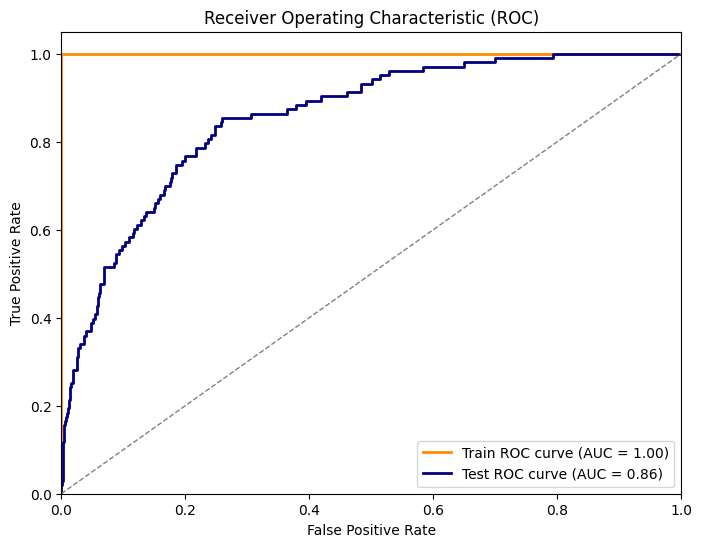

In [ ]:
classifier = MLPClassifier(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = clf.predict_proba(X_train)[:, 1]
y_test_prob = clf.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

Accuracy: 90.39%


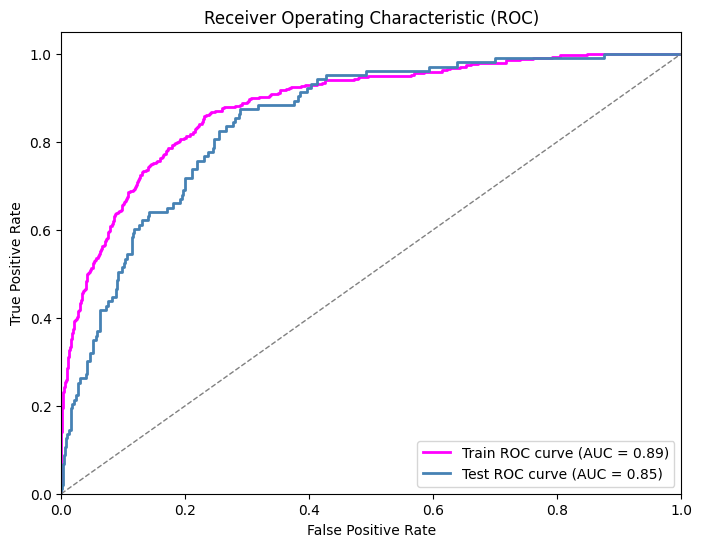

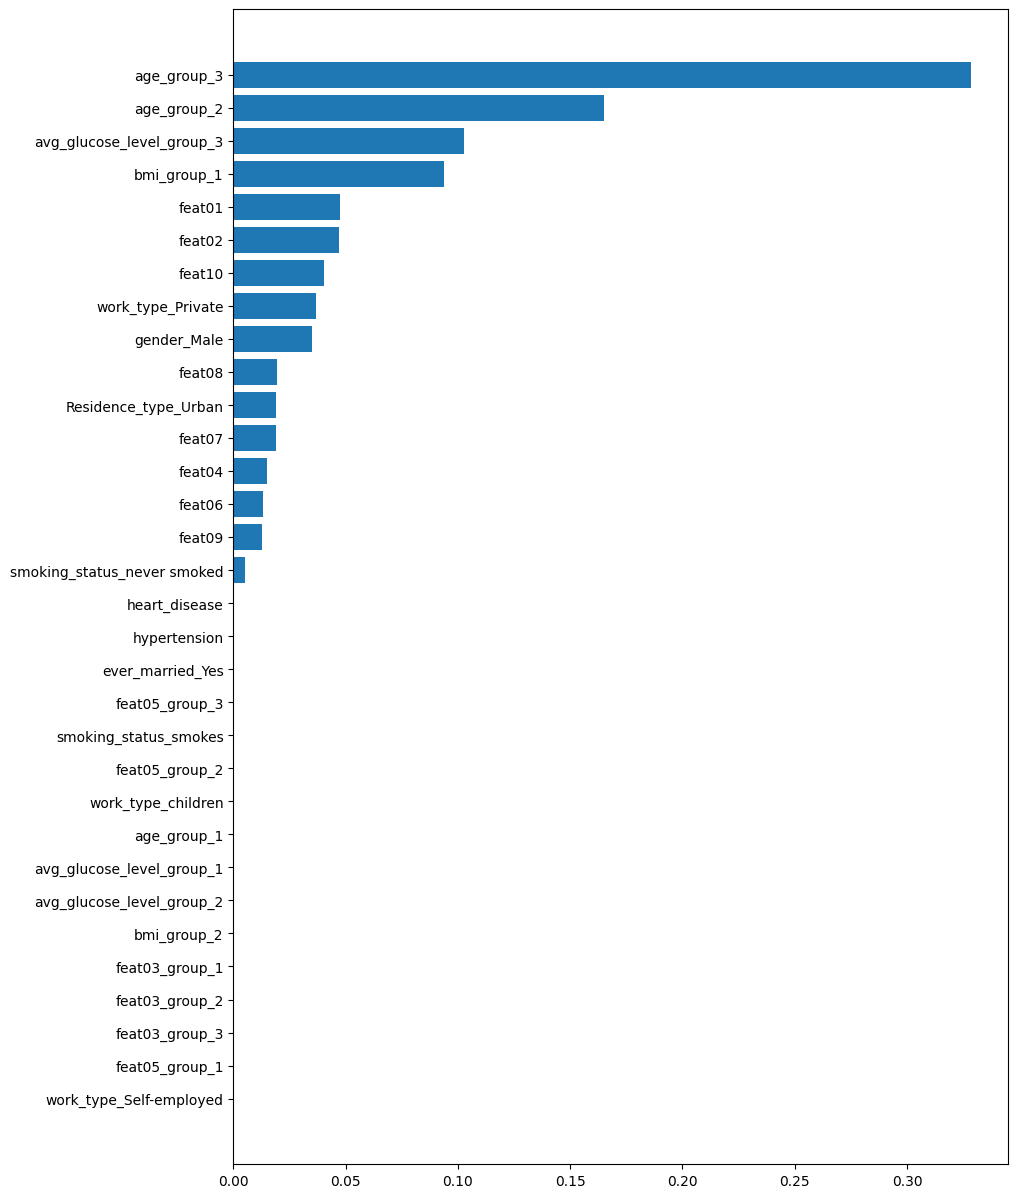

In [ ]:
# fit model no training data
model = XGBClassifier(learning_rate = 0.3, n_estimators = 400, max_depth = 10, min_child_weight = 8, scale_pos_weight = 0.07)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='fuchsia', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='steelblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
# model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()

### Feature selection

In [ ]:
# train_selected, drop_lst= toad.selection.select(frame = X_train,
#                                                 target=y_train,  
#                                                 iv = 0.03, corr = 0.6, 
#                                                 return_drop=True 
#                                                 )
# print("keep:",train_selected.shape[1],
#       "drop empty:",len(drop_lst['empty']),
#       "drop iv:",len(drop_lst['iv']),
#       "drop corr:",len(drop_lst['corr']))

# def output_iv_importance(train_selected,label_col):
#     feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
#     feat_import_iv=feat_import_iv['iv']
#     feat_import_iv = feat_import_iv.reset_index()
#     feat_import_iv.columns = ['name','iv']
#     return feat_import_iv
# df_iv=output_iv_importance(train_selected, y_train)
# df_iv = df_iv[df_iv['iv'] < 0.95]
# df_iv.shape



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

X_train = X_train[X_train.columns[sorted_idx][0:14]]
X_test = X_test[X_test.columns[sorted_idx][0:14]]

# df_iv

IndexError: index 29 is out of bounds for axis 0 with size 26

Accuracy: 92.07%


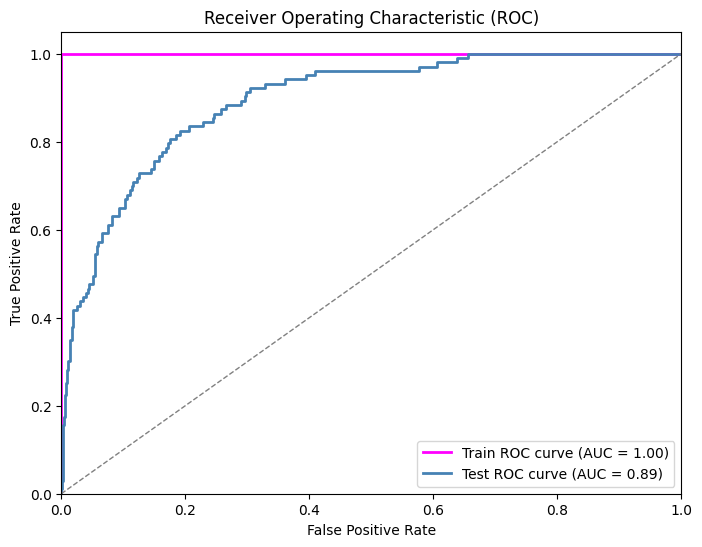

In [ ]:
# fit model no training data
model = XGBClassifier()#learning_rate = 0.3, n_estimators = 400, max_depth = 10, min_child_weight = 8, scale_pos_weight = 0.07)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='fuchsia', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='steelblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

<BarContainer object of 26 artists>

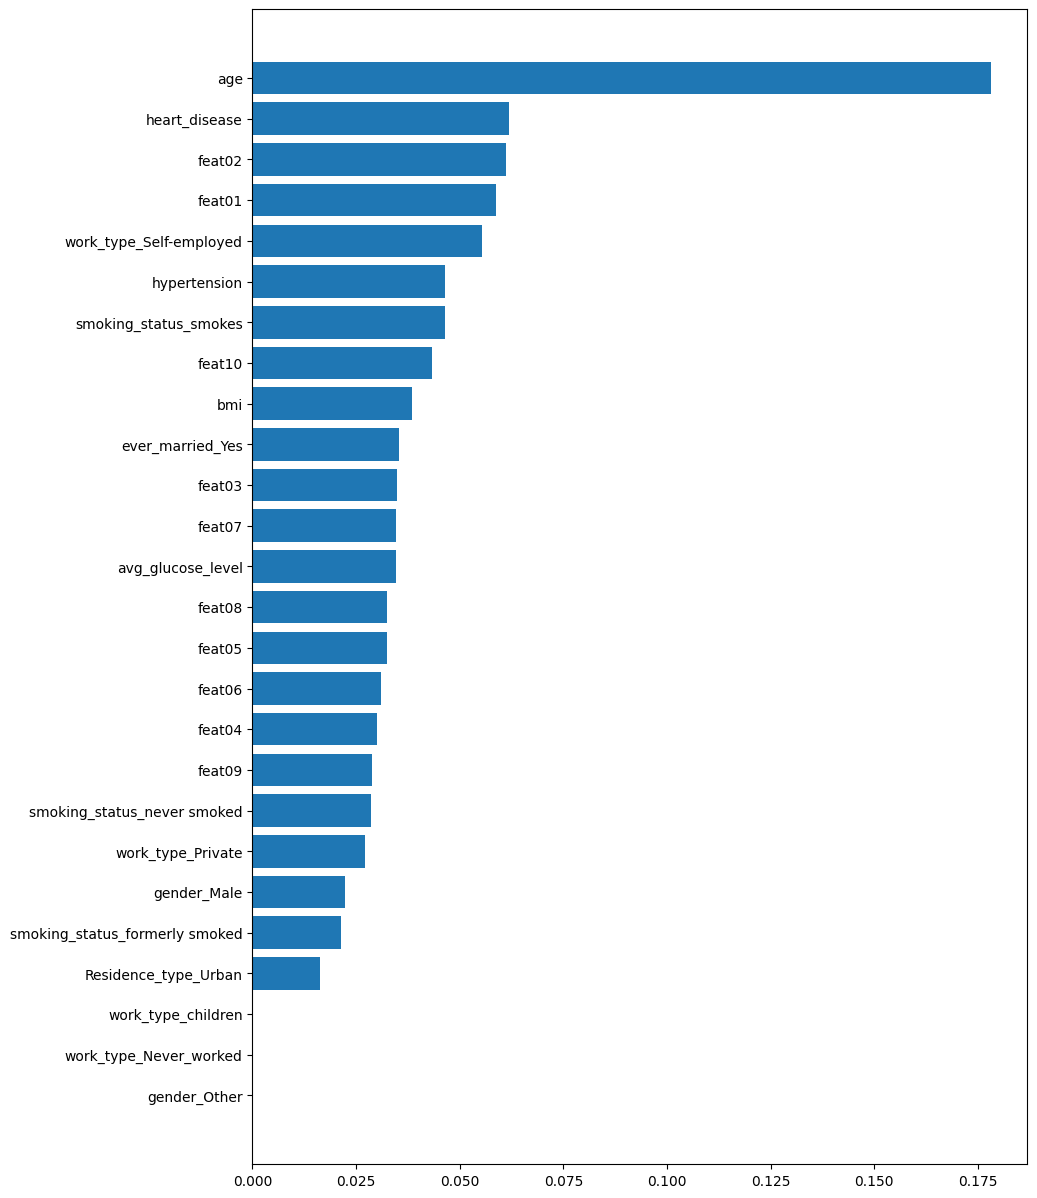

In [ ]:
# model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score

X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']


numerical_features = ['age', 'avg_glucose_level', 'bmi', 'feat01', 'feat02',
       'feat03', 'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09',
       'feat10', 'heart_disease', 'hypertension']
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_features = [ 'Residence_type', 'smoking_status', 'work_type', 'ever_married']
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

classifier = MLPClassifier(random_state=0, max_iter = 500, learning_rate = 0.01, hidden_layer_sizes = (100, 100, 100))

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])

stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies_test = []
accuracies_train = []

for train_index, test_index in stratified_kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc_train = balanced_accuracy_score(y_train, clf.predict(X_train))
    acc_test = balanced_accuracy_score(y_test, y_pred)
    accuracies_test.append(acc_test)
    accuracies_train.append(acc_train)



# Calculate the mean AUC score from cross-validation
mean_accuracy_train = np.mean(accuracies_train)
mean_accuracy_test = np.mean(accuracies_test)


print('train:', accuracies_train, 'test:', accuracies_test)


KeyError: "['id'] not found in axis"

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the range of hyperparameters
param_dist = {
    'classifier__hidden_layer_sizes': [(50, ), (100, ), (150, ), (50, 50), (100, 100), (150, 150)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
    'classifier__max_iter': randint(200, 1000),  # Range from 200 to 1000
    'classifier__early_stopping': [True, False],
    'classifier__validation_fraction': [0.1, 0.2, 0.3]
}

# Create an MLPClassifier
classifier = MLPClassifier(random_state=0)

# Use the pipeline and include the classifier inside the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=50, cv=stratified_kf, scoring='balanced_accuracy', verbose=1, n_jobs=-1, random_state=42)

# Fit the random search to find the best hyperparameters
random_search.fit(X, y)

# Get the best hyperparameters
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Balanced Accuracy:", best_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__early_stopping': False, 'classifier__hidden_layer_sizes': (150,), 'classifier__learning_rate': 'constant', 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 493, 'classifier__solver': 'sgd', 'classifier__validation_fraction': 0.1}
Best Balanced Accuracy: 0.6728957370899817
